# Noise Interferometry Test
This tests the functionality of the noise interferometry module of ooipy

## Sections
- Compute Cross Correlation for specified window

First, let's import all dependancies

In [1]:
import os
import sys
cwd = os.getcwd()
ooipy_dir = os.path.dirname(cwd) + '/ooipy'
sys.path.append(ooipy_dir)
from matplotlib import pyplot as plt
import datetime
import numpy as np
from obspy import read,Stream, Trace
from obspy.core import UTCDateTime
from ooipy.hydrophone import Noise_Interferometry as NI
import pickle
import scipy
from gwpy.timeseries import TimeSeries
import seaborn as sns
import gwpy

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Calculating NCF for 1 Average Period

In [2]:
# Create instance of NCF object
avg_time = 60 #minute
start_time = datetime.datetime(2017,3,10,0,0,0)
node1 = '/LJ01C'
node2 = '/PC01A'
filter_cutoffs = [20, 70]
W = 30

NCF0 = NI.NCF(avg_time, start_time, node1, node2, filter_cutoffs, W, verbose=True, whiten=True)
NCF0 = NI.calculate_NCF(NCF0)

   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering and Whitening Data for Node 1...
   Filtering and Whitening Data for Node 2...
   Correlating Data...
   Time to Calculate NCF for 1 Average Period: 66.16511726379395 




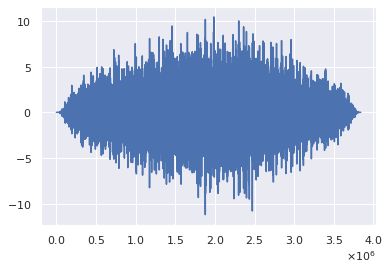

In [127]:
plt.plot(NCF0.NCF)

# Loop Through 2 instances of NCF Calculation

In [6]:
NI.calculate_NCF_loop(2, node1, node2, 1, start_time, W,  filter_cutoffs, verbose=True, whiten=True)

Calculting NCF for Period 1:
   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering and Whitening Data for Node 1...
   Filtering and Whitening Data for Node 2...
   Correlating Data...
   Time to Calculate NCF for 1 Average Period: 9.200584411621094 


Calculting NCF for Period 2:
   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering and Whitening Data for Node 1...
   Filtering and Whitening Data for Node 2...
   Correlating Data...
   Time to Calculate NCF for 1 Average Period: 9.003805160522461 




## Reading in Checkpoints

Checkpoint for k = 0


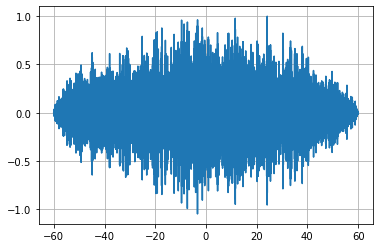

In [20]:
ckpt_name = './ckpts/ckpt_0.pkl'

with open(ckpt_name, 'rb') as f:
    xcorr = pickle.load(f)
    k = pickle.load(f)

print('Checkpoint for k =',k)

#Plot Xcorr
dt = 1/64000
t = np.arange(-xcorr.shape[0]*dt/2,xcorr.shape[0]*dt/2,dt)

plt.plot(t,xcorr)
plt.grid()

## Testing List of Functions ReWrite

In [6]:
num_periods = 1
avg_time = 60 #minutes
start_time = datetime.datetime(2017,3,10,0,0,0) # time of first sample
node1 = '/LJ01C'
node2 = '/PC01A'
filter_data = True
W = 30

Noise_Interferometry.calculate_NCF_loop(num_periods, node1, node2, avg_time, start_time, W=30, verbose=True)

Calculting NCF for Period 1:
   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering Data...
   Correlating Data...
./ckpts/ckpt_0.pkl
   Time to Calculate NCF for 1 Average Period: 85.9322018623352 




## Reading Header File

In [41]:
header_name = os.path.dirname(os.getcwd()) + '/NCFs/ckpts_5/0HEADER.pkl'
with open(header_name,'rb') as f:
    header = pickle.load(f)
print(header.start_time)
print(header.filter_cutoffs)
print(header.htype)
print(header.num_periods)
print(header.node1)
print(header.node2)
print(header.W)

2017-03-10 00:00:00
[12, 30]
broadband
384
/LJ01C
/PC01A
90


## Evaluating Available NCFs

Number of Available Hours: 314


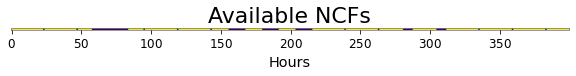

In [44]:
#60 hours
num_periods = 400
NCF_available = np.zeros((num_periods,1))
num_available = 0

for k in range(num_periods):   
    ckpt_name = os.path.dirname(os.getcwd()) + '/NCFs/ckpts_5/ckpt_'+ str(k) +'.pkl'
    try:
        with open(ckpt_name, 'rb') as f:
            xcorr_1hr = pickle.load(f)
        NCF_available[k] = 1
        num_available = num_available + 1
    except:
        NCF_available[k] = 0




Number of Available Hours: 314


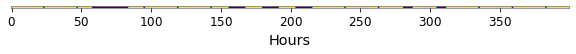

In [47]:
fig = plt.figure(figsize=(10,30))
ax = plt.imshow(NCF_available.T)

ax.axes.get_yaxis().set_visible(False)
plt.xlabel('Hours')
#plt.title('Available NCFs', fontsize=22)

print(f'Number of Available Hours: {num_available}')

## Stacking Data from ./ckpts/

In [12]:
import progressbar
bar = progressbar.ProgressBar(maxval=400, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

#60 hours
invalid = 0
for k in range(400):   
    ckpt_name = os.path.dirname(os.getcwd()) + '/NCFs/ckpts_5/ckpt_'+ str(k) +'.pkl'
    try:
        with open(ckpt_name, 'rb') as f:
            xcorr_1hr = pickle.load(f)
    except:
        invalid = invalid + 1
        continue
    if np.isnan(np.sum(xcorr_1hr)):
        invalid = invalid + 1
    else:
        if k == 0:
            xcorr = xcorr_1hr
        else:
            xcorr = xcorr + xcorr_1hr
    bar.update(k)

bar.finish()
#Make XCORR Sum XCORR average
#xcorr = xcorr/15360
#xcorr = xcorr/7200
xcorr = xcorr/11040
#xcorr = xcorr/8480
print(invalid)

124


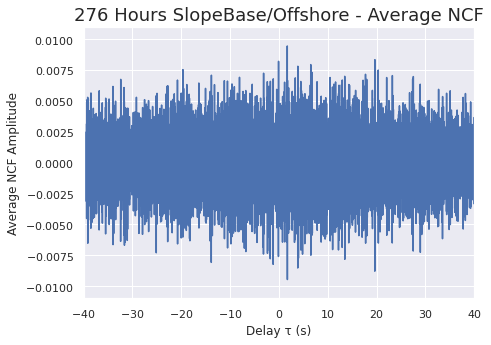

In [13]:
#Plot Xcorr
dt = 1/64000
t = np.arange(-xcorr.shape[0]*dt/2,xcorr.shape[0]*dt/2,dt)

sns.set()
f1 = plt.figure(figsize=(7,5))
plt.plot(t, xcorr)
plt.title('276 Hours SlopeBase/Offshore - Average NCF',fontsize=18)
plt.xlim([-40,40])
plt.xlabel('Delay τ (s)')
plt.ylabel('Average NCF Amplitude')
plt.ylim([-0.011, 0.011])

f1.savefig('276_hours_slopebase_offshore_avg_consty.png',dpi=500)

In [8]:
from plotly import express as px
fig=px.scatter(x=t,y=xcorr)
fig.write_html('xcorr_SlopeBase.html')

## Experimenting with GWpy Filtering

In [105]:
# Get some audio
# Create instance of NCF object
avg_time = 1 #minute
start_time = datetime.datetime(2017,3,10,0,0,0)
node1 = '/LJ01C'
node2 = '/PC01A'
filter_cutoffs = [80, 120]
W = 30

NCF0 = NI.NCF(avg_time, start_time, node1, node2, filter_cutoffs, W, verbose=True, whiten=True)
NCF0 = NI.get_audio(NCF0)

   Getting Audio from Node 1...
   Getting Audio from Node 2...


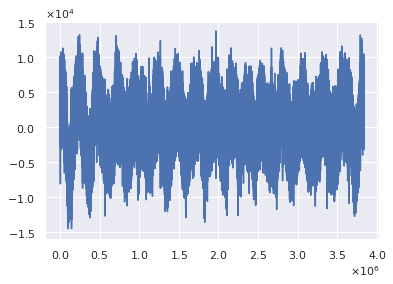

In [112]:
h1 = np.ndarray.flatten(NCF0.node1_data)
plt.plot(h1)

In [113]:
ts = TimeSeries(h1, 64000)

In [115]:
ts_white = ts.whiten()

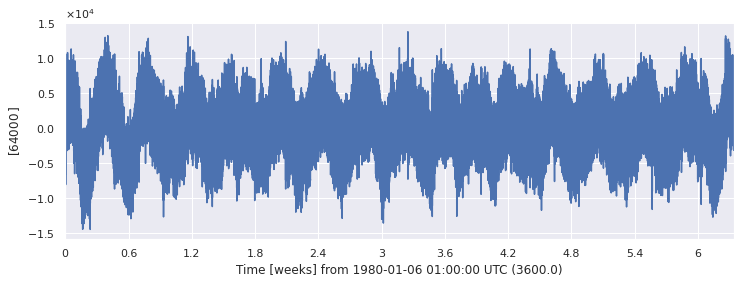

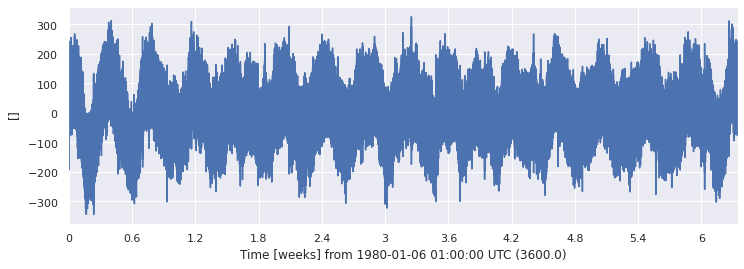

In [116]:
p1 = ts.plot()
p2 = ts_white.plot()

(0.0, 1000.0)

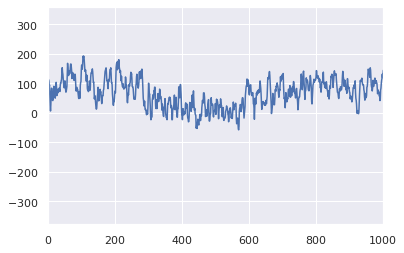

In [120]:
plt.plot(ts_white.value)
plt.xlim(0,1000)

Text(0.5, 1.0, 'Data with Whitening')

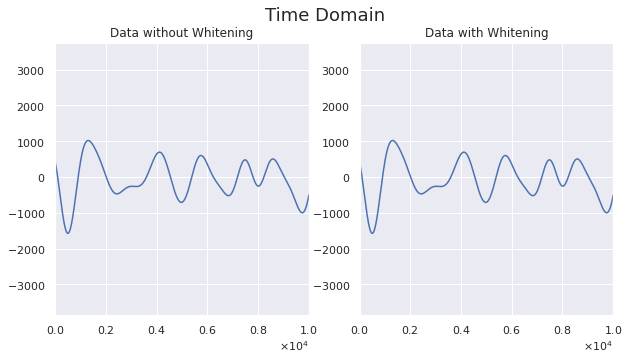

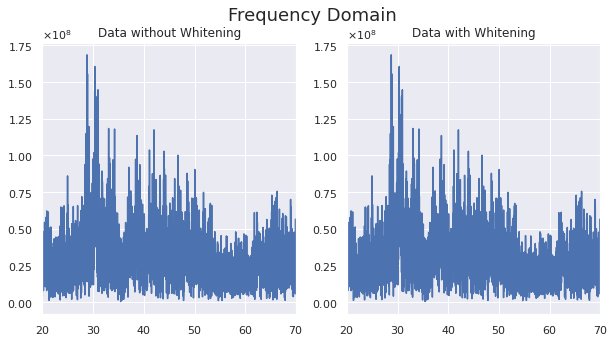

In [96]:
h1_white = np.ndarray.flatten(NCF_white.node1_processed_data)
h1_nowhite = np.ndarray.flatten(NCF_nowhite.node1_processed_data)

f = np.linspace(0, 64000, len(h1_processed))

sns.set()


# new style method 1; unpack the axes
fig, ((ax1, ax2)) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig.suptitle('Time Domain', fontsize=18)

ax1.plot(h1_nowhite)
ax1.set_title('Data without Whitening')
ax1.set_xlim(0,10000)
ax2.plot(h1_white)
ax2.set_title('Data with Whitening')
ax2.set_xlim(0,10000)


fig2, ((ax1, ax2)) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig2.suptitle('Frequency Domain', fontsize=18)

ax1.plot(f,np.abs(scipy.fft.fft(h1_nowhite)))
ax1.set_title('Data without Whitening')
ax1.set_xlim([20, 70])
ax2.plot(f,np.abs(scipy.fft.fft(h1_white)))
ax2.set_title('Data with Whitening')




#plt.plot(f, np.abs(scipy.fft.fft(h1_processed)))
#plt.xlim([0, 200])
#plt.title('Whitened Data')

# Testing Low Frequency Hydrophone NCF

In [39]:
import os
import sys
cwd = os.getcwd()
ooipy_dir = os.path.dirname(cwd) + '/ooipy'
sys.path.append(ooipy_dir)
from matplotlib import pyplot as plt
import datetime
import numpy as np
from obspy import read,Stream, Trace
from obspy.core import UTCDateTime
from ooipy.hydrophone import Noise_Interferometry as NI
import pickle
import scipy
from gwpy.timeseries import TimeSeries
import seaborn as sns

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
num_periods = 144 
avg_time = 60 #minutes
start_time = datetime.datetime(2017,3,10,0,0,0) # time of first sample
node1 = 'Eastern_Caldera'
node2 = 'Central_Caldera'
filter_cutoffs = [10, 20]
W = 10
htype = 'low_frequency'
whiten= False

NCF_object = NI.NCF(avg_time, start_time, node1, node2, filter_cutoffs, W, htype=htype, verbose=True, whiten=False)

In [46]:
NCF_object = NI.calculate_NCF(NCF_object)

   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering and Whitening Data for Node 1...
   Filtering and Whitening Data for Node 2...
   Correlating Data...
   Time to Calculate NCF for 1 Average Period: 9.174785852432251 




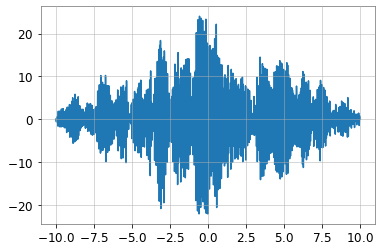

In [49]:
#Plot Xcorr
dt = 1/200
t = np.arange(-NCF_object.NCF.shape[0]*dt/2,NCF_object.NCF.shape[0]*dt/2,dt)

plt.plot(t, NCF_object.NCF)

In [23]:
# Get needed data from NCF_object
h1_data = NCF_object.node1_data[0,:100]
Fs = NCF_object.Fs
filter_cutoffs = NCF_object.filter_cutoffs
whiten = NCF_object.whiten

ts = NI.preprocess_audio_single_thread(h1_data, Fs, filter_cutoffs, whiten)

In [29]:
ts.whiten()

ValueError: window is longer than input signal